# DATOS

In [1]:
# Import de bibliotecas necesarias
import pandas as pd
import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df = pd.read_csv("Crimenes.csv")
df.head()

X = df[['Asesinatos', 'Asaltos', 'Poblacion Urbana', 'Violaciones']]

In [3]:
fips_codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
df['code'] = df['Estado'].map(fips_codes.set_index('state')['code'])
df.head()

,Estado,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,code
0,Alabama,13.2,236,58,21.2,AL
1,Alaska,10.0,263,48,44.5,AK
2,Arizona,8.1,294,80,31.0,AZ
3,Arkansas,8.8,190,50,19.5,AR
4,California,9.0,276,91,40.6,CA


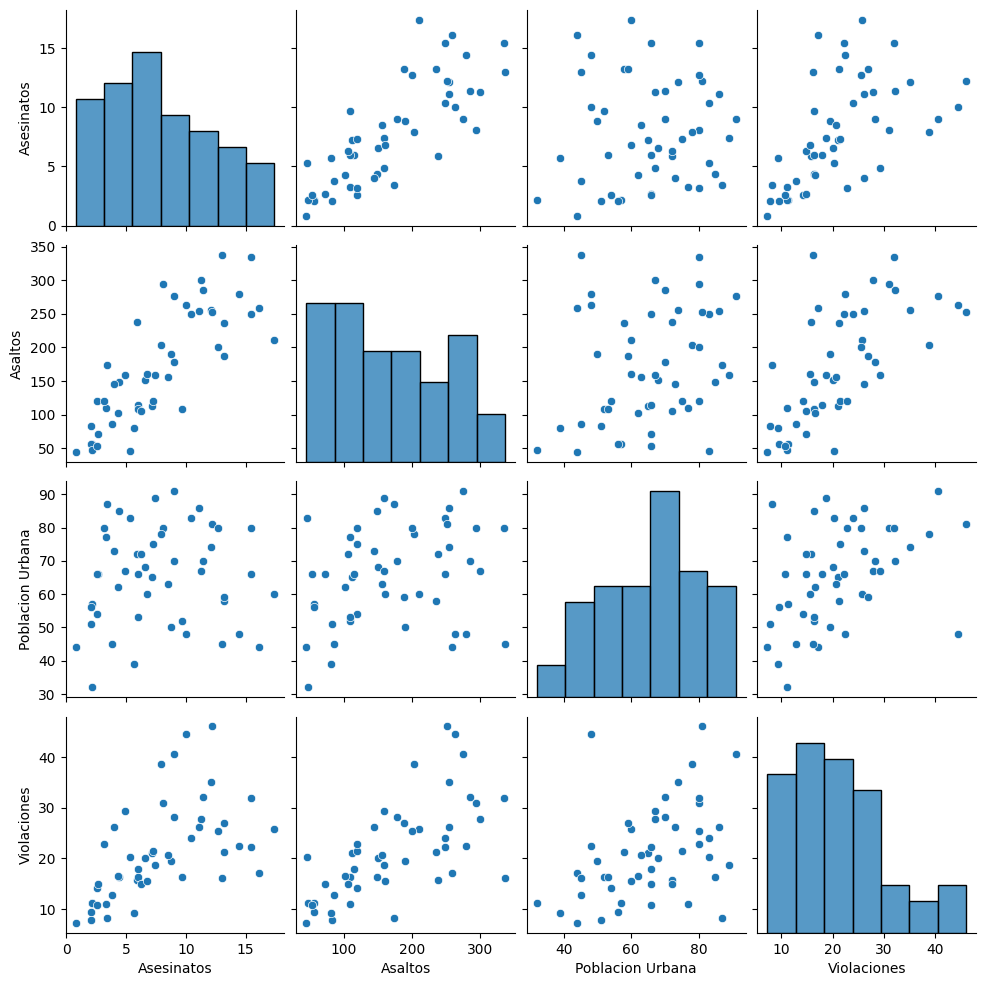

In [4]:
sns.pairplot(df)
plt.show()

# KMEANS

c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

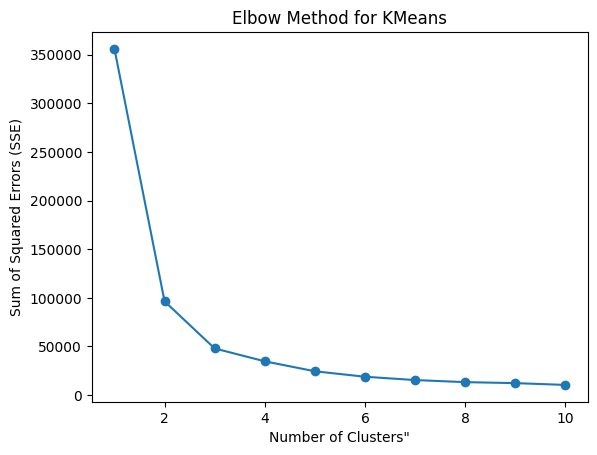

In [4]:
sse = []

# Probamos con un rango de valores de k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Graficamos el método del codo
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of Clusters"')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

c:\Users\piamp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


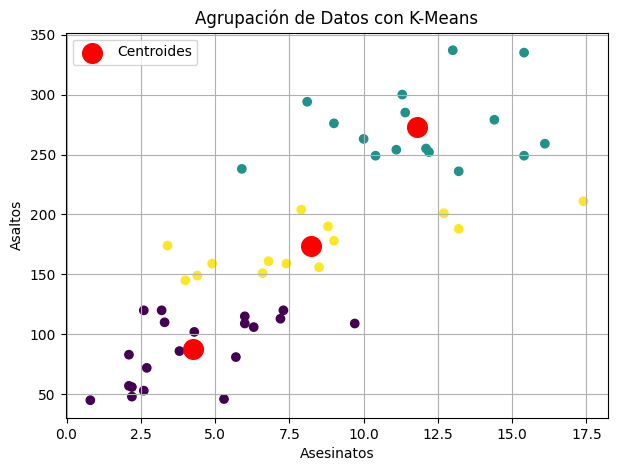

In [5]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X)

plt.figure(figsize=(7, 5))
plt.scatter(X['Asesinatos'], X['Asaltos'], c=clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='o', label='Centroides')

plt.xlabel('Asesinatos')
plt.ylabel('Asaltos')
plt.title('Agrupación de Datos con K-Means')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\piamp\AppData\Local\Temp\ipykernel_18340\2719383561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XKmeans["Clusters"] = clusters


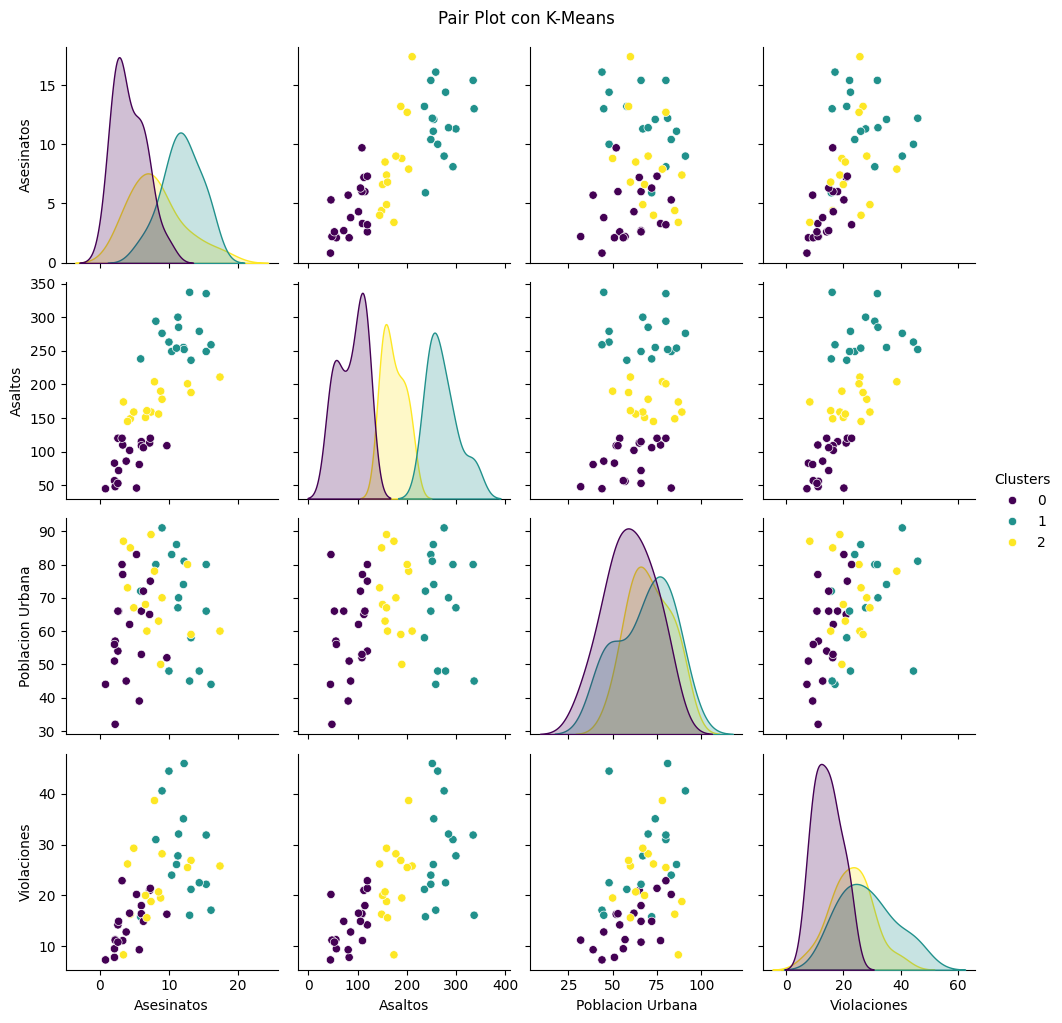

In [6]:
XKmeans = X
XKmeans["Clusters"] = clusters

sns.pairplot(XKmeans, hue='Clusters', palette='viridis')
plt.suptitle('Pair Plot con K-Means', y=1.02)
plt.show()

In [29]:
XKmeans["Estado"] = df["code"]
mapeo_etiquetas = {0: 'Seguro', 1: 'Peligroso', 2: 'Alerta'}
XKmeans['Seguridad'] = XKmeans['Clusters'].map(mapeo_etiquetas)
print(XKmeans)

    Asesinatos  Asaltos  Poblacion Urbana  Violaciones  Clusters Estado  \
0         13.2      236                58         21.2         1     AL   
1         10.0      263                48         44.5         1     AK   
2          8.1      294                80         31.0         1     AZ   
3          8.8      190                50         19.5         2     AR   
4          9.0      276                91         40.6         1     CA   
5          7.9      204                78         38.7         2     CO   
6          3.3      110                77         11.1         0     CT   
7          5.9      238                72         15.8         1     DE   
8         15.4      335                80         31.9         1     FL   
9         17.4      211                60         25.8         2     GA   
10         5.3       46                83         20.2         0     HI   
11         2.6      120                54         14.2         0     ID   
12        10.4      249  

In [33]:
fig = px.choropleth(
    XKmeans,
    locations='Estado',
    locationmode='USA-states',
    color='Seguridad',
    scope='usa',
    color_discrete_sequence=["red", "yellow", "green"],
)

fig.update_layout(title_text='Mapa de Clusters')
fig.show()

# MEAN SHIFT